# Recipe Recommender System: Similarity Scoring

**Objective**: Create a novel similarity scoring system to recommend most relevant recipes

E-commerce websites have been using recommendation systems to increase conversion and expose related products to customers. Companies like Amazon and Netflix have been very successful in their recommendation systems.

There are two datasets:

- Recipe features
- Similarity scores rated by humans: 1 (not similar at all), 2 (not really similar), 3 (similar) and 4 (very similar)

In this notebook, I will use an ensemble approach: using multiple algorithms to predict similarities from each dataset and then combining them using weighted averages. This is treated as an unsupervised learning problem as there is no defined target variable. 

This notebook consists of five sections:
1. Data exploration
2. Data preprocessing
3. Modelling
4. Conclusion and future works
5. References

More details will be discussed in each section. 

In [1]:
import pandas as pd
import numpy as np
import re
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

In [2]:
recipe_info = pd.read_csv('data/recipe_info.csv').set_index('recipe_id')
similarity_scores = pd.read_csv('data/similarity_scores.csv')

`recipe_info` contains recipe features such as country, dish category and prep time. A content-based recommendation could be created from this dataset.

In [3]:
recipe_info.head()

,country,country_secondary,dish_category,dish_type,diet_type,carbohydrate_base,carbohydrate_category,protein,protein_cut,protein_type,family_friendly,spice_level,prep_time
recipe_id,,,,,,,,,,,,,
2,India,India,Stove top / bowl food,Curry,Fish,Basmati,Rice,Shellfish,Prawns,Fish & Seafood,No,No Spice,25
5,Italy,Italy,Protein&Veg,Meat & Side veg,Meat,white potatoes,Potato,Beans,Butter beans,Pulses,No,Mild,35
9,Thailand,Thailand,Stove top / bowl food,Curry,Vegan,Basmati,Rice,Tofu,Protein not found,Vegetarian,No,Spicy,25
16,Great Britain,Great Britain,Protein&Veg,Fish & side veg,Fish,Carb not found,NaN,Oily Fish,Trout,Fish & Seafood,No,No Spice,20
19,Tunisia,Tunisia,Protein&Veg,Egg dish,Vegetarian,Millet,Grains,Eggs,Eggs,Dairy & Eggs,No,No Spice,30


`similarity_scores` contains scores rated by humans for pairs of recipes.

In [4]:
similarity_scores.head()

,user_id,message_datetime,action_datetime,recipe_a,recipe_b,score
0,10141,2016-07-28 15:22:03,2016-07-28 16:32:05,548,292,2
1,10163,2016-08-11 12:06:08,2016-08-11 12:08:28,584,288,1
2,10163,2016-08-15 11:04:12,2016-08-15 11:11:40,288,553,3
3,10011,2016-08-20 22:42:23,2016-08-20 22:43:05,271,498,2
4,10141,2016-08-25 10:38:09,2016-08-25 11:27:41,585,89,1


## 1. Data exploration


From my experience, recipes coming from the same country are likely to be more similar. From the bar plot below, I can expect to see some recipes being more likely to have higher number of similar recipes than others (Italian vs Russian).

I also found different names for the same country. This will be dealt with in section 2 Data preprocessing.

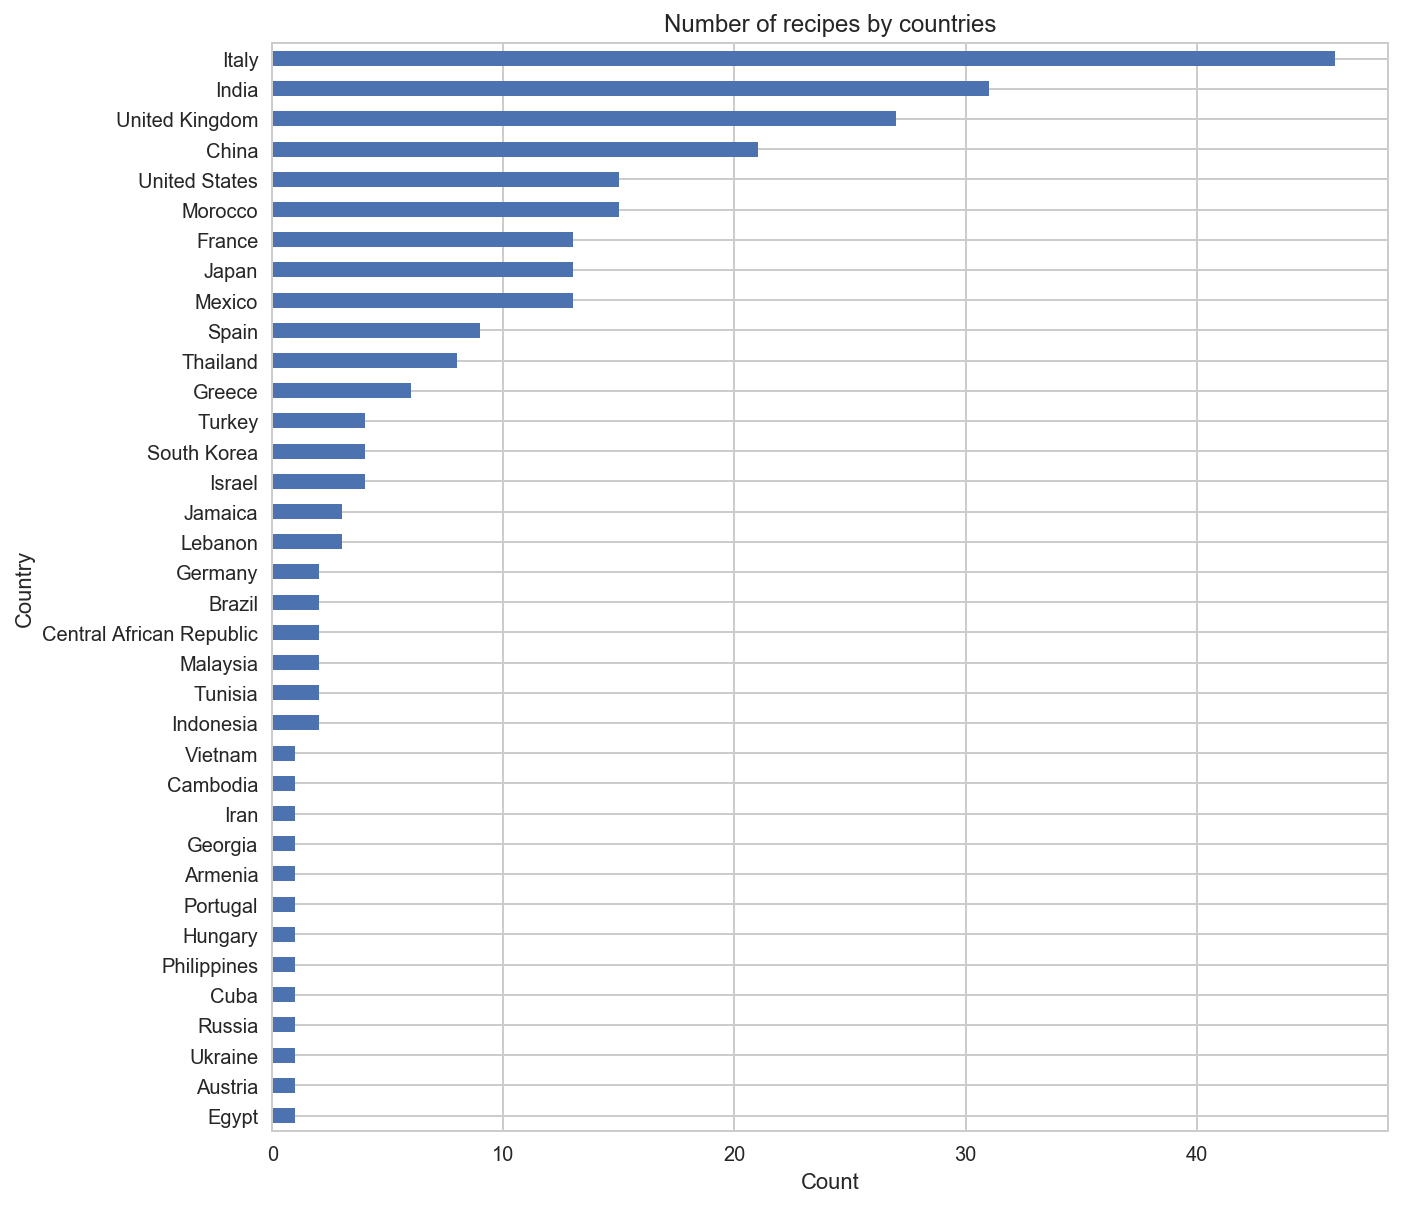

In [5]:
figure(figsize=(10,10))

# different names for the same country have been found
country_mapping = {'Israel and the Occupied Territories': 'Israel',
                   'Korea, Republic of (South Korea)': 'South Korea',
                   'United States of America (USA)': 'United States',
                   'Great Britain': 'United Kingdom',
                   'Korea, Democratic Republic of (North Korea)': 'North Korea'}

ax = recipe_info.country.replace(country_mapping)\
                        .value_counts(ascending=True)\
                        .plot(kind='barh', title='Number of recipes by countries', 
                              color=sns.color_palette(n_colors=1))
_ = ax.set(xlabel='Count', ylabel='Country')

Another main differential feature could be whether recipes are family friendly. Families usually order a larger amount than individuals. Having more family friendly recipes can potentially increase sales as there will be more relevant option for family customers.

From the following plot, it looks like recipes mainly target for individual/non-family audiences. Could family friendly recipes be something to focus on in the near future?

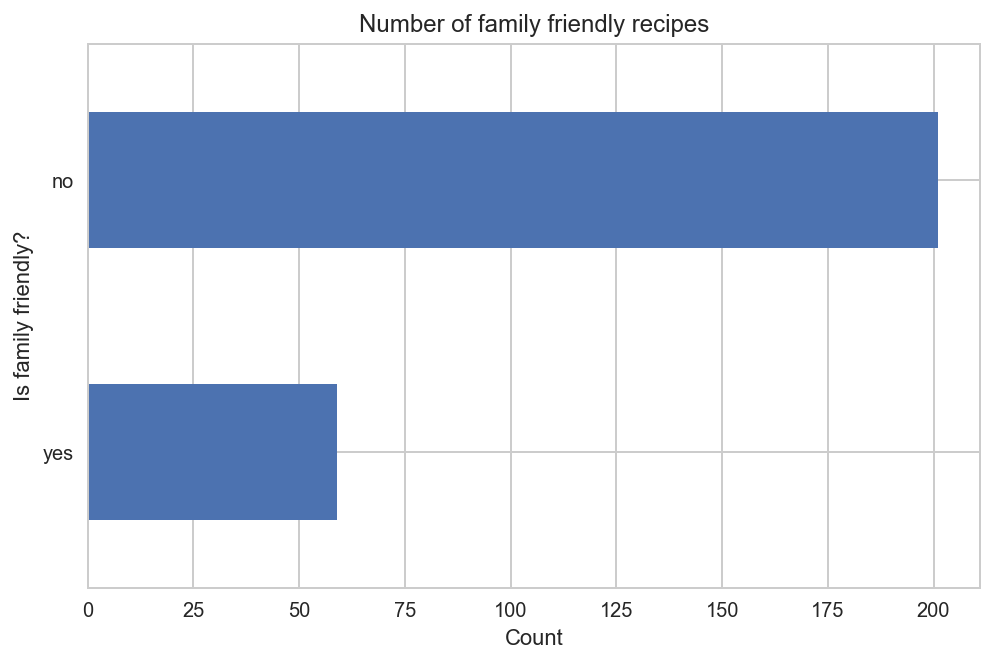

In [6]:
figure(figsize=(8, 5))
ax = recipe_info.family_friendly.str.lower()\
                                .value_counts(ascending=True)\
                                .plot(kind='barh', 
                                      title='Number of family friendly recipes', 
                                      color=sns.color_palette(n_colors=1))
_ = ax.set(xlabel='Count', ylabel='Is family friendly?')

Now looking at the similarity scores rated by users, we can see that only seven users rated (and there is one user who submitted 1835 times!). Similarity is very subjective, differing from user to user. More different users would definitely improve similarity predictions. 

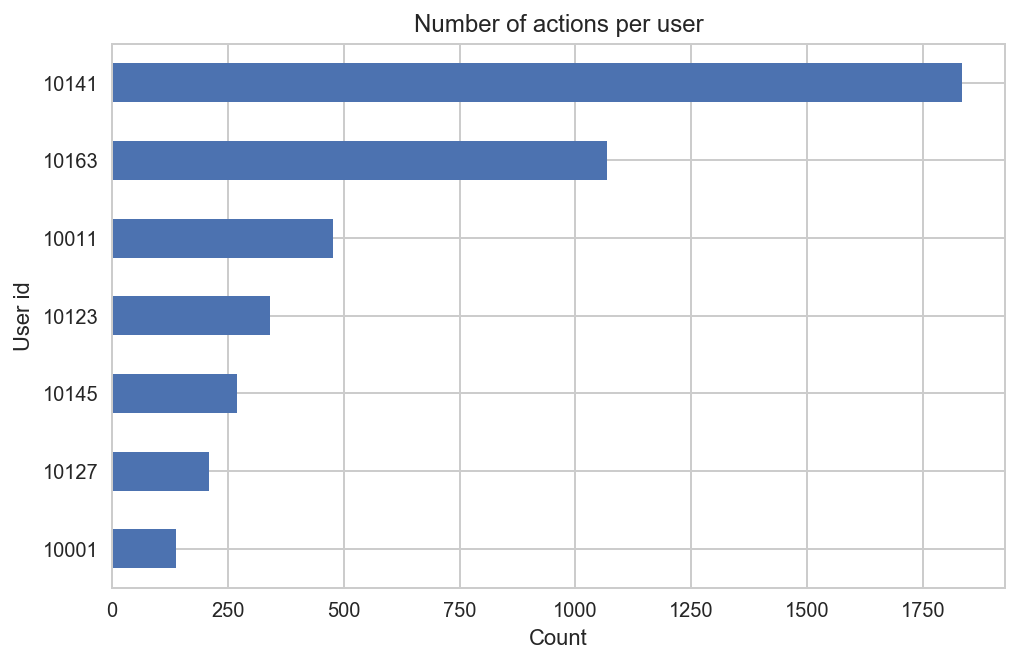

In [7]:
figure(figsize=(8, 5))
ax = similarity_scores.user_id.value_counts(ascending=True)\
                              .plot(kind='barh', title='Number of actions per user', 
                                    color=sns.color_palette(n_colors=1))
_ = ax.set(xlabel='Count', ylabel='User id')

Could there be bias from users? Some users might tend to rate lower/higher scores or simply just clicked score 1 consistently. More data will be required to understand user rating bias and adjust accordingly.

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


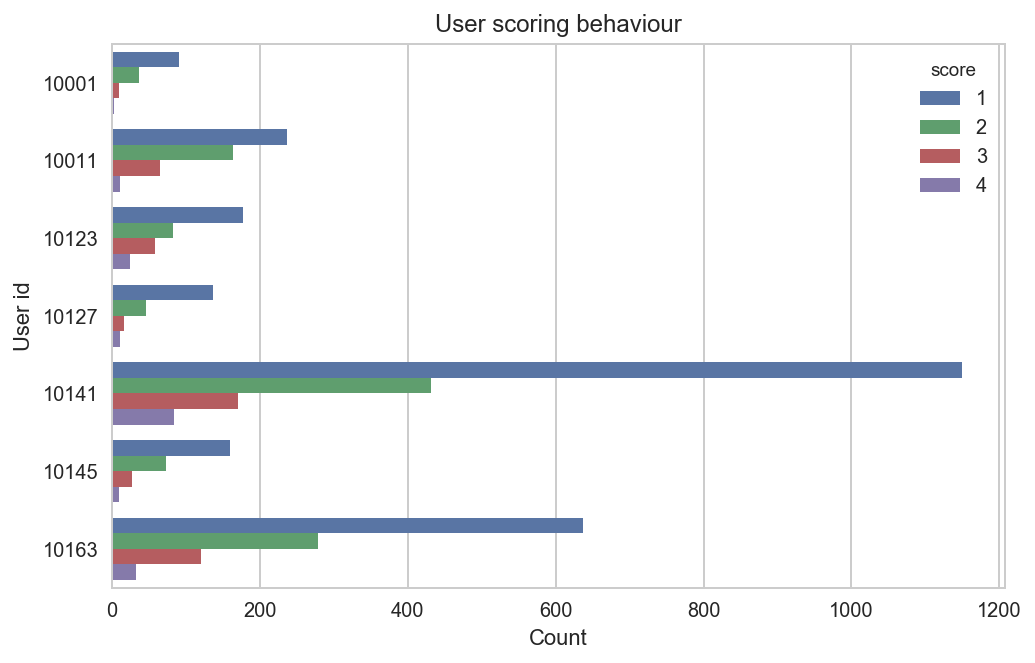

In [8]:
figure(figsize=(8, 5))
ax = sns.countplot(y='user_id', hue='score', data=similarity_scores)
_ = ax.set(xlabel='Count', ylabel='User id', title='User scoring behaviour')

The user similarity rating dataset is sparse, only has about 2.2% of all possible combinations of recipe info (see calculation below). By using both recipe features and user ratings in a recommendation algorithm, we can avoid a cold start which is a common problem in many recommendation systems. Because of the sparsity, Bayesian inference could work well here.

In [9]:
# number of combinations
n_recipe_combo = len(list(combinations(recipe_info.index.values, 2)))

# number of user rating combinations available
n_rating_combo = np.unique(np.sort(similarity_scores[['recipe_a','recipe_b']], 1), axis=0).shape[0]

# proportion of available user rating combinations out of all possible combinations
print('Similarity scoring data coverage: {:.2g}%'.format(100 * n_rating_combo / n_recipe_combo))

Similarity scoring data coverage: 2.2%


## 2. Data preprocessing

During data exploration, I found that there are many missing values, duplications and etc. to fix before the dataset can be used for modelling. Details of data exploration and preprocessing are not shown here as they are not as interesting as the main discussion (see section 3 Modelling).

Main steps:

- Using general knowledge to clean some of the features
- Creating dummy variables for categorical data
- Standardising feature scales


### 2.1 Cleaning recipe feature data

In [10]:
# deduplicate countries (country_mapping was defined earlier)
recipe_info.country_secondary.replace(country_mapping, inplace=True)

In [11]:
# fill missing values

# feature: carbohydrate_category
recipe_info.carbohydrate_category.fillna('None', inplace=True)

# feature: dish_category
# looking at the dish_type of missing values in dish_category, those missing values seem to be all 'Salads'
recipe_info.dish_category.fillna('Salads', inplace=True)  

# feature: protein, protein_cut, protein_type
# looking at 'protein', 'protein_cut', 'protein_type' from similar recipes to infer missing values
missing_protein_idx = recipe_info[(recipe_info.protein.isnull()) | 
                                  (recipe_info.protein_cut.isnull()) | 
                                  (recipe_info.protein_type.isnull())].index.tolist()

def fillna_protein(x):
    if x.protein_cut == 'Mozzarella':
        x.protein, x.protein_type = 'Cheese', 'Dairy & Eggs'

    elif 'Beef' in x.protein_cut:
        x.protein, x.protein_type = 'Beef', 'Poultry & Meat'

    elif x.protein_cut == 'Protein not found':
        x.protein_cut = 'None'

    elif x.protein_cut == 'Smoked Mackerel':
        x.protein, x.protein_type = 'Smoked Fish', 'Fish & Seafood'

    elif x.protein == 'Chicken':
        x.protein_cut = 'Breast Chicken'
        
    return x

recipe_info.loc[missing_protein_idx, ['protein', 'protein_cut', 'protein_type']] = \
    recipe_info.loc[missing_protein_idx, ['protein', 'protein_cut', 'protein_type']]\
               .fillna('None').apply(fillna_protein, axis=1)

In [12]:
# convert prep time to int and take average if it is a range
def convert_prep_time(x):
    if '-' in x:
        return np.mean(list(map(int, x.split('-'))))
    else:
        return float(x) 
    
recipe_info.prep_time = recipe_info.prep_time.apply(convert_prep_time)

In [13]:
# convert ordinal feature spice_level to level 1 to 3
recipe_info.spice_level = recipe_info.spice_level.map({'No Spice': 1, 'Mild': 2, 'Spicy': 3})

# convert boolean variable to 0 and 1
recipe_info.family_friendly = recipe_info.family_friendly.str.lower().map({'no': 0, 'yes': 1})

In [14]:
# get columns that are strings
str_cols = [x for x in recipe_info.columns if recipe_info[x].dtype == 'O']

# replace space or symbols with '_' and convert to lower case (to make it nice and neat)
recipe_info[str_cols] = recipe_info[str_cols].apply(lambda x: x.str.replace(r"\W", '_')  # replace with '_'
                                                               .str.replace('_+', '_')   # replace '_'s with '_'
                                                               .str.lower())

In [15]:
# convert nominal features to dummy variables
recipe_info_dummies = pd.get_dummies(recipe_info)

# standardise features to the same scale
recipe_info_std = (recipe_info_dummies - recipe_info_dummies.mean()) / recipe_info_dummies.std(ddof=0)

In [16]:
recipe_info_std.head()

,family_friendly,spice_level,prep_time,country_armenia,country_austria,country_brazil,country_cambodia,country_central_african_republic,country_china,country_cuba,...,protein_cut_steak_pork,protein_cut_strips_beef,protein_cut_trout,protein_cut_vegetables,protein_type_dairy_eggs,protein_type_fish_seafood,protein_type_none,protein_type_poultry_meat,protein_type_pulses,protein_type_vegetarian
recipe_id,,,,,,,,,,,,,,,,,,,,,
2,-0.541786,-0.636039,-0.780515,-0.062137,-0.062137,-0.088045,-0.062137,-0.088045,-0.296422,-0.062137,...,-0.210183,-0.062137,-0.062137,-0.062137,-0.559581,2.417045,-0.304034,-0.836269,-0.340411,-0.125
5,-0.541786,0.676423,0.394211,-0.062137,-0.062137,-0.088045,-0.062137,-0.088045,-0.296422,-0.062137,...,-0.210183,-0.062137,-0.062137,-0.062137,-0.559581,-0.413728,-0.304034,-0.836269,2.937623,-0.125
9,-0.541786,1.988885,-0.780515,-0.062137,-0.062137,-0.088045,-0.062137,-0.088045,-0.296422,-0.062137,...,-0.210183,-0.062137,-0.062137,-0.062137,-0.559581,-0.413728,-0.304034,-0.836269,-0.340411,8.000
16,-0.541786,-0.636039,-1.367878,-0.062137,-0.062137,-0.088045,-0.062137,-0.088045,-0.296422,-0.062137,...,-0.210183,-0.062137,16.093477,-0.062137,-0.559581,2.417045,-0.304034,-0.836269,-0.340411,-0.125
19,-0.541786,-0.636039,-0.193152,-0.062137,-0.062137,-0.088045,-0.062137,-0.088045,-0.296422,-0.062137,...,-0.210183,-0.062137,-0.062137,-0.062137,1.787050,-0.413728,-0.304034,-0.836269,-0.340411,-0.125


Looking at the correlation heat map below, it can be seen that some features are highly correlated e.g. features `country` and `secondary_country`. It is not good to have correlated features as they provide similar information. It will be dealt with in the next section.

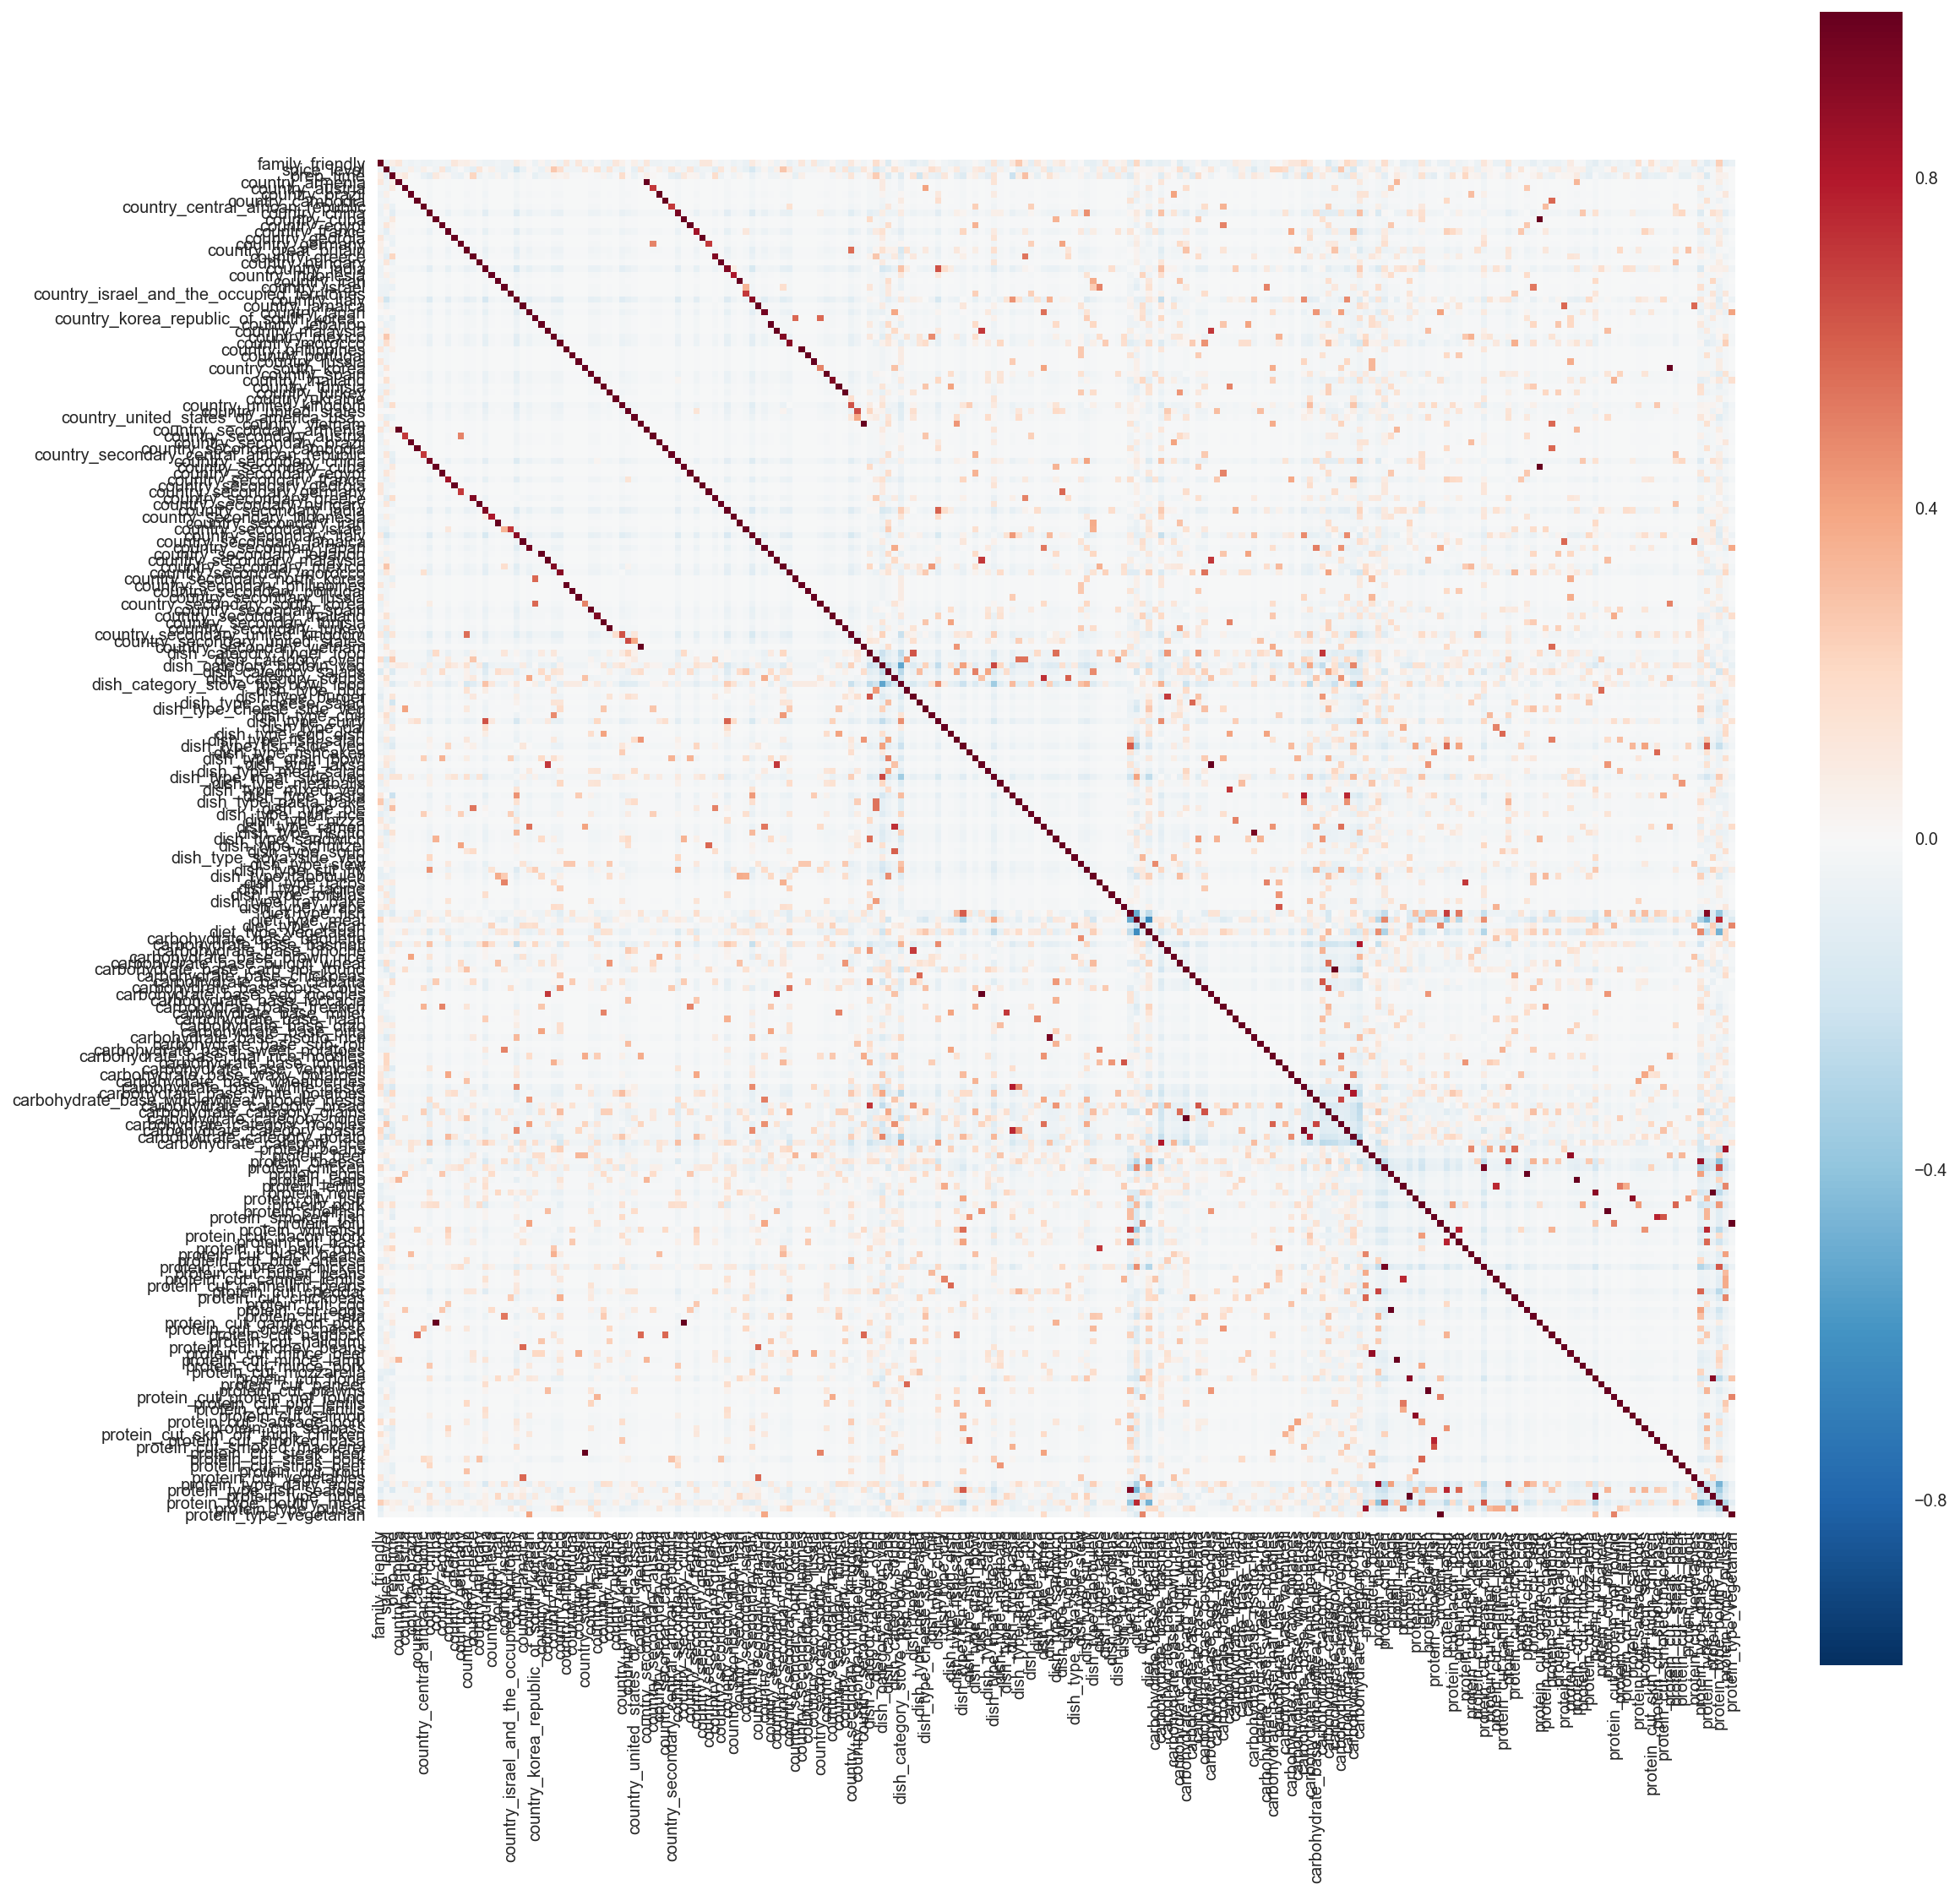

In [17]:
figure(figsize=(18,18))
corrmat = recipe_info_std.corr()
sns.heatmap(corrmat, square=True);

### 2.2 Principal component analysis (PCA)

Before calculating cosine similarities (or any similarity measures), I will conduct a PCA to reduce correlations between features and improve computational performance. If there is (large) correlation between features, distance measure will not make sense. 

It is very important to standardise the features before conducting a PCA, which has already been done in section 2 Data preprocessing. Otherwise features will larger range will dominate, effectively having more weights than other features.


Let's first look at the explained variance to determine the most appropriate number of principal components. As we see in the following figure, using the top 104 principal components allows us to capture 95% of the variance. Therefore I will transform the dataset `recipe_info` to this new 104-dimensional feature subspace. 

95% variance is captured using the top 104 principal components


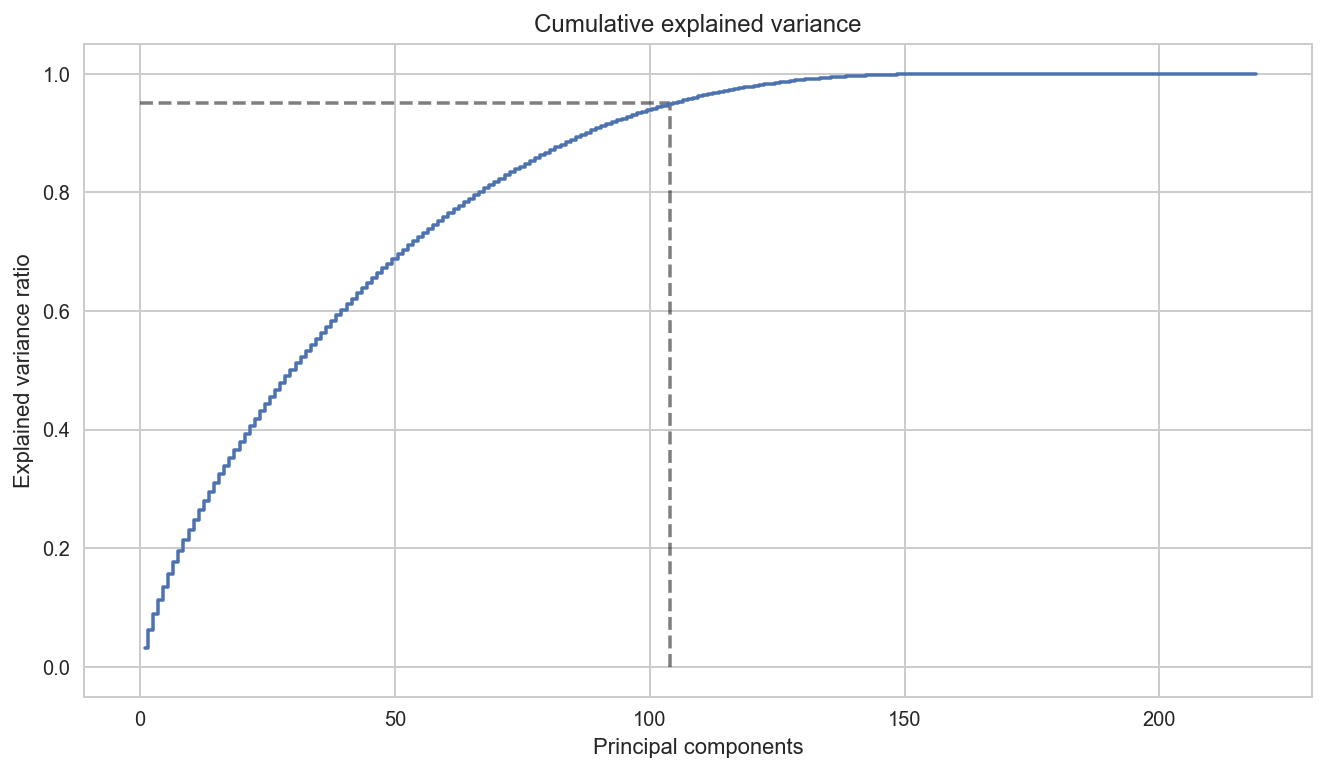

In [18]:
# PCA
pca = PCA(n_components=None)
pca.fit_transform(recipe_info_std)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
n_components = np.argmax(cum_var_exp >= 0.95)

print('95% variance is captured using the top {} principal components'.format(n_components))

figure(figsize=(11, 6))
x_ve = range(1, len(var_exp) + 1)
plt.step(x_ve, cum_var_exp, where='mid')
plt.hlines(0.95, 0, n_components, linestyles='dashed', alpha=0.5)
plt.vlines(104, 0, 0.95, linestyles='dashed', alpha=0.5)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Cumulative explained variance')
plt.show()

In [19]:
pca = PCA(n_components=n_components)
recipe_info_pca = pca.fit_transform(recipe_info_std)

### 2.3 Cleaning similarity score data

- Keep onlt recipe ids that appear in the content dataset
- Feature `action_datetime` can be used to create a decaying weight for older ratings

In [20]:
similarity_scores = similarity_scores[(similarity_scores.recipe_a.isin(recipe_info.index)) & 
                                      (similarity_scores.recipe_b.isin(recipe_info.index))]

In [21]:
similarity_scores['action_date'] = similarity_scores.action_datetime.str.split(' ', expand=True)[0]

In [22]:
similarity_scores.head()

,user_id,message_datetime,action_datetime,recipe_a,recipe_b,score,action_date
0,10141,2016-07-28 15:22:03,2016-07-28 16:32:05,548,292,2,2016-07-28
1,10163,2016-08-11 12:06:08,2016-08-11 12:08:28,584,288,1,2016-08-11
2,10163,2016-08-15 11:04:12,2016-08-15 11:11:40,288,553,3,2016-08-15
3,10011,2016-08-20 22:42:23,2016-08-20 22:43:05,271,498,2,2016-08-20
5,10011,2016-08-18 12:54:08,2016-08-23 15:10:50,271,317,1,2016-08-23


## 3. Modelling

I will use an ensemble approach to combine multiple methods to evaluate the recipe similarities:
- **Cosine similarity** and **Jaccard similarity** on recipe features, because they work better (than e.g. Euclidean distance) in high dimensional space with sparse dataset.


- **Bayesian inference** on similarity scores, because there is only a small amount of comparison data. Combining prior beliefs with experimental evidence, we can continuously update our beliefs about the similarities as we gather more user scoring data.

---

### Why not Euclidean distance for high dimensional and sparse dataset?
    
- Euclidean distance is defined as:   
    
    $$||\pmb q − \pmb p|| = \sqrt{(\pmb q − \pmb p) . (\pmb q − \pmb p)} = \sqrt{||\pmb p||^2 + ||\pmb q||^2 - 2\pmb p \pmb q}$$
    
    where $p = (p_1, p_2, ..., p_n)$ and $||\pmb p|| = \sqrt{p_1^2 + p_2^2 + ... + p_n^2}$ (similar for q and $||\pmb q||$)
    
    Fro sparse dataset, $\pmb p \pmb q$ is mostly near 0. This means $||\pmb q − \pmb p|| \approx \sqrt{||\pmb p||^2 + ||\pmb q||^2}$ which is a quadratic mean of their lengths - not a good measure of distance.
    
- An example shows that Euclidean distance cannot distinguish two vector pairs: http://mlwiki.org/index.php/Euclidean_Distance

---

### 3.1 Cosine similarity based on recipe features

Cosine similarity measures the cosine of the angle between two non-zero vectors. It looks at recipes that may be co-regulated or associated (correlated). Cosine similarity ranges from -1 to +1 and values close to 1 indicate high similarity. The denominator is for 'unit-length normalization' (a.k.a. 'cosine normalization')

$$cosine \: similarity = cos(\pmb x, \pmb y) = \frac {\pmb x \cdot \pmb y}{||\pmb x|| \cdot ||\pmb y||}$$

Cosine similarity is calculated below and is rescaled to range(0, 1). This can be thought of as:

- Max similarity if two vectors point in the same direction
- Min similarity if two vectors point in the opposite directions

This rescale will be useful when combining with the Bayesian model later.

In [23]:
cos_sim = cosine_similarity(recipe_info_pca)

cos_sim = pd.DataFrame(cos_sim, 
                       index=recipe_info.index.values, 
                       columns=recipe_info.index.values)
cos_sim = (cos_sim + 1) / 2  # rescale to range(0, 1)
cos_sim.head()

,2,5,9,16,19,20,30,53,54,57,...,1270,1276,1277,1278,1279,1280,1281,1282,1283,1284
2,1.000000,0.452420,0.520761,0.512133,0.476756,0.480676,0.469551,0.477466,0.490978,0.457721,...,0.460243,0.470442,0.451572,0.814407,0.532053,0.481856,0.848775,0.449362,0.509268,0.472782
5,0.452420,1.000000,0.481634,0.480403,0.484374,0.487941,0.508381,0.469640,0.509981,0.470550,...,0.462858,0.487696,0.527756,0.474099,0.471251,0.487642,0.505232,0.453913,0.501210,0.551735
9,0.520761,0.481634,1.000000,0.487304,0.491056,0.481304,0.480003,0.483074,0.488009,0.474894,...,0.484819,0.480457,0.473997,0.483691,0.500300,0.489368,0.496897,0.476051,0.489767,0.493932
16,0.512133,0.480403,0.487304,1.000000,0.494895,0.490966,0.465639,0.486653,0.473838,0.478649,...,0.591194,0.496865,0.479811,0.556150,0.511836,0.488897,0.513041,0.478605,0.485507,0.481150
19,0.476756,0.484374,0.491056,0.494895,1.000000,0.841151,0.504166,0.513402,0.488757,0.481603,...,0.482969,0.490957,0.469584,0.485855,0.483497,0.491902,0.477584,0.500157,0.489443,0.483298


### 3.2 Jaccard similarity based on recipe features

- Jaccard is commonly known as 'intersection over union'. if A and B are finite sample sets, Jaccard similarity is defined as

    $$J(A, B) = \frac {|A \cap B|}{|A \cup B|}$$

    With range

    $$0 \le J(A, B) \le 1$$

- In this case, I use the dataframe before one-hot encoding, scaling and PCA transformations. Using this dataset I can compare the categorical data. For example if $a_1 = b_1$ then the nominator will be added by one and the denominator is the number of features.

- I will also categorise `prep_time` into (short, medium, long) because the precision duration is not important and the actual preparation time differs from user to user. 

- From the correlation heat map shown above, `country` and `country_secondary` appear to have high correlation. This is rather obvious as most `country` = `country_secondary`. Without using PCA, we would be 'double-counting' their similarities. Therefore I will remove `country_secondary` just for calculating Jaccard similarity. 

---

#### Generalised Jaccard similarity

If $\pmb A = (a_1, a_2,...,a_n)$ and $\pmb B = (b_1, b_2,...,b_n)$ with all real $a_i,b_i \ge 0$ the Jaccard similarity is defined as 

$$J(\pmb A, \pmb B) = \frac {\sum_{i} min(a_i, b_i)}{\sum_{i} max(a_i, b_i)}$$






In [24]:
def get_prep_time_cat(time):
    if time < 30.:
        return 'short'
    elif 30. <= time < 60.:
        return 'medium'
    else:
        return 'long'

recipe_info_jaccard = recipe_info.copy()
recipe_info_jaccard['prep_time_cat'] = recipe_info_jaccard['prep_time'].apply(get_prep_time_cat)
recipe_info_jaccard.drop(['prep_time', 'country_secondary'], axis=1, inplace=True)

In [25]:
recipe_info_jaccard.head()

,country,dish_category,dish_type,diet_type,carbohydrate_base,carbohydrate_category,protein,protein_cut,protein_type,family_friendly,spice_level,prep_time_cat
recipe_id,,,,,,,,,,,,
2,india,stove_top_bowl_food,curry,fish,basmati,rice,shellfish,prawns,fish_seafood,0,1,short
5,italy,protein_veg,meat_side_veg,meat,white_potatoes,potato,beans,butter_beans,pulses,0,2,medium
9,thailand,stove_top_bowl_food,curry,vegan,basmati,rice,tofu,protein_not_found,vegetarian,0,3,short
16,great_britain,protein_veg,fish_side_veg,fish,carb_not_found,none,oily_fish,trout,fish_seafood,0,1,short
19,tunisia,protein_veg,egg_dish,vegetarian,millet,grains,eggs,eggs,dairy_eggs,0,1,medium


In [26]:
def jaccard_similarity_score(df):
    data = df.values
    len_, n_features = data.shape
    idx_ = range(len_)
    sim = np.ones([len_, len_])
    
    for c in combinations(idx_, 2):
        sim[c] = sim[c[::-1]] = (data[c[0]] == data[c[1]]).sum() / n_features
        
    return pd.DataFrame(sim, index=df.index, columns=df.index)

In [27]:
jac_sim = jaccard_similarity_score(recipe_info_jaccard)
jac_sim.head()

recipe_id,2,5,9,16,19,20,30,53,54,57,...,1270,1276,1277,1278,1279,1280,1281,1282,1283,1284
recipe_id,,,,,,,,,,,,,,,,,,,,,
2,1.000000,0.083333,0.500000,0.416667,0.166667,0.166667,0.250000,0.166667,0.333333,0.083333,...,0.166667,0.166667,0.250000,0.500000,0.333333,0.166667,0.583333,0.083333,0.416667,0.166667
5,0.083333,1.000000,0.083333,0.166667,0.250000,0.250000,0.250000,0.166667,0.250000,0.166667,...,0.250000,0.333333,0.250000,0.166667,0.083333,0.250000,0.250000,0.083333,0.250000,0.416667
9,0.500000,0.083333,1.000000,0.166667,0.083333,0.083333,0.166667,0.083333,0.250000,0.000000,...,0.083333,0.083333,0.166667,0.083333,0.250000,0.083333,0.250000,0.000000,0.250000,0.250000
16,0.416667,0.166667,0.166667,1.000000,0.250000,0.250000,0.166667,0.166667,0.166667,0.083333,...,0.416667,0.166667,0.250000,0.500000,0.333333,0.166667,0.333333,0.083333,0.250000,0.083333
19,0.166667,0.250000,0.083333,0.250000,1.000000,0.666667,0.416667,0.500000,0.333333,0.166667,...,0.250000,0.333333,0.166667,0.250000,0.083333,0.250000,0.083333,0.333333,0.333333,0.166667


### 3.3 Similarity based on user rated data

This scoring dataset is equivalent to a 4-star rating system where the higher the score, the more similar the comparison is. One way of seeing a 4-star rating system is a more continuous version of an 'upvote/downvote' system. In an 'upvote/downvote' system, for a given true upvote ratio $p$ and $N$ votes, the number of upvotes will look like a Binomial random variable with parameter $p$ and $N$. Importantly $p$ is the variable that we want to perform Bayesian inference on.

In the case with 4-star rating, we can set n stars rewarded as equivalent to rewarding $\frac{n}{4}$, i.e. the scores will become [1/4, 2/4, 3/4, 4/4]. $p$ will be modelled as a Binomial distribution (the likelihood term in Bayes' theorem).

Without much prior knowledge about distributions of similarity scores $p$ look like, I will set a uninformative prior $Beta(a=1, b=1)$

Conveniently Beta and Binomial distributions have a conjugate relationship, meaning that the posterior distribution has a closed form solution (MCMC is not required) and is a Beta distribution. Since a lot less computation power is needed, this method can be used in online learning where the model can be updated as new evidence is received.

Posterior distribution of $p$:
$$Beta(a', b')$$ 
where $$a' = a + S$$ and $$b' = b + (U - S)$$

where U is the number of users who rated, and S is the sum of all ratings, using the equivalence scheme described above.

The mean of the Beta posterior distribution is then calculated from:
$$\mu = \frac{a'}{a' + b'}$$

The mean will then be scaled to range between 0 and 1, and output as the similarity score.

In [28]:
def bayes_similarity_score(data, all_recipe_ids, rating_rewards, prior=(1,1)):
    """
    data : pandas DataFrame
        Similarity scores rated by users
    all_recipe_ids : list
        A list of all available recipe ids
    rating_rewards : dict
        {"rating column name": "rating reward"}
    prior : tuple
        (alpah, beta) of prior Beta distribution parameters
    """
    # order similarity scores to obtain unique combinations i.e. (x vs y) is equivalent to (y vs x)
    data[['recipe_a','recipe_b']] = np.sort(data[['recipe_a','recipe_b']], 1)

    # create a frequency table. for each recipe combination, count the number of times a score was given
    user_rated_sim = pd.crosstab([data.recipe_a, data.recipe_b], data.score)
    
    # prior Beta distribution parameters
    alpha, beta = prior[0], prior[1]

    # ---calculate posterior distribution using the equations specified above---

    # U is the number of users who rated
    user_rated_sim['U'] = user_rated_sim.sum(axis=1)

    # S is the sum of all ratings using the new rating scheme n/4
    user_rated_sim['S'] = (user_rated_sim[list(rating_rewards.keys())] * 
                             list(rating_rewards.values()) / max(rating_rewards.values())).sum(axis=1)

    # a_ is a shape parameter in posterior Beta distribution
    user_rated_sim['a_'] = alpha + user_rated_sim['S']

    # b_ is a shape parameter in posterior Beta distribution
    user_rated_sim['b_'] = beta + user_rated_sim['U'] - user_rated_sim['S']

    # calculate the mean of the posterior Beta distribution
    user_rated_sim['post_mean'] = user_rated_sim['a_'] / (user_rated_sim['a_'] + user_rated_sim['b_'])
    
    user_rated_sim.reset_index(inplace=True)
    
    # output pairwise similarity
    n_recipes = len(all_recipe_ids)
    recipe_idx_map = dict(zip(all_recipe_ids, range(n_recipes)))  # define mapping between recipe_ids and index location
    pairwise_sim = np.empty([n_recipes, n_recipes])  # create empty pairwise simularity matrix
    pairwise_sim.fill(np.nan)

    for r, row in user_rated_sim.iterrows():
        i, j = recipe_idx_map[int(row['recipe_a'])], recipe_idx_map[int(row['recipe_b'])]
        pairwise_sim[(i, j)] = pairwise_sim[(j, i)] = row['post_mean']
    
    return pd.DataFrame(pairwise_sim, columns=all_recipe_ids, index=all_recipe_ids)

In [29]:
user_rated_sim = bayes_similarity_score(data=similarity_scores, 
                                        all_recipe_ids=recipe_info.index.tolist(),
                                        rating_rewards = {1: 1, 2: 2, 3: 3, 4: 4},
                                        prior=(1,1))
user_rated_sim.head()

,2,5,9,16,19,20,30,53,54,57,...,1270,1276,1277,1278,1279,1280,1281,1282,1283,1284
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.416667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.4 Ensemble

The final step in this modelling section is to combine the two sets of similarities together by taking the weighted average. This is a hybrid approach to combine outputs of weak learners, each of which might be able to pick up some useful signals. A hybrid approach can often provide more accurate scores than pure approaches (Netflix is a good example of the use of hybrid recommender systems). A hybrid approach can also be used to overcome some of the common problems in recommender systems such as cold start and the sparsity problem.

The following code is written in a way that allows combining any number of similarity sets. The weights in the weighted average calculation can easily be adjusted, depending on how much we believe in each method. For example, the user-rated similarity score is sparse and potential biasing, we can assign a lower weight. As more evidence is gathered, we can dynamically increase the weight because it will be more trustworthy. We might also want to set a cap to the weight because we do not want to completely wash out the content-based similarities. For now, I will use the following weights: cosine -> 2, Jaccard -> 2, user_rated -> 1.

If a similarity score is not available in one of the methods, it will not be taken into account in the weighted average calculation.

In [30]:
def ensemble_similarity_score(data, all_recipe_ids, weights):
    """
    Calculate weighted average of multiple sets of similarity scores
    
    data : np.array
        numpy array of similarity scores
    all_recipe_ids : list
        A list of all available recipe ids
    weights: list
        A list of weights corresponding to each set of similarity scores
    """
    masked_sim_data = np.ma.masked_array(data, np.isnan(data))
    ensemble_sim = np.ma.average(masked_sim_data, axis=0, weights=weights).filled(np.nan)
    ensemble_sim = pd.DataFrame(ensemble_sim, index=all_recipe_ids, columns=all_recipe_ids)
    return ensemble_sim

In [31]:
ensemble_sim = ensemble_similarity_score(data=np.array([cos_sim.values, jac_sim.values, user_rated_sim.values]),
                                         all_recipe_ids=recipe_info.index.tolist(),
                                         weights=[2, 2, 1])
ensemble_sim.head()

,2,5,9,16,19,20,30,53,54,57,...,1270,1276,1277,1278,1279,1280,1281,1282,1283,1284
2,1.000000,0.267877,0.510381,0.464400,0.321711,0.323671,0.359775,0.322066,0.412156,0.270527,...,0.313455,0.318554,0.350786,0.657204,0.432693,0.324261,0.716054,0.266348,0.462967,0.319724
5,0.267877,1.000000,0.282483,0.323535,0.367187,0.368971,0.379190,0.318153,0.379991,0.318608,...,0.356429,0.410514,0.388878,0.320383,0.277292,0.368821,0.377616,0.268623,0.375605,0.484201
9,0.510381,0.282483,1.000000,0.326985,0.287195,0.282319,0.323335,0.283204,0.369005,0.237447,...,0.284076,0.281895,0.320332,0.283512,0.375150,0.286350,0.373449,0.238025,0.369883,0.371966
16,0.464400,0.323535,0.326985,1.000000,0.372448,0.370483,0.316153,0.326660,0.339535,0.280991,...,0.503930,0.331766,0.364906,0.528075,0.422585,0.327782,0.423187,0.280969,0.367754,0.282242
19,0.321711,0.367187,0.287195,0.372448,1.000000,0.753909,0.460416,0.506701,0.411045,0.324135,...,0.366485,0.412145,0.318125,0.367928,0.283415,0.370951,0.280459,0.416745,0.411388,0.324982


## 4. Conclusion

In this case study, exploration and preprocessing were conducted for the given datasets and a novel similarity scoring system was created using an ensemble approach. Aiming for deployment, the code was written in a very efficient way to allow potential online learning. The ensemble approach also provides an easy way to incorporate other similarity scores calculated from other methods. 

### Future works

- Rating decay: If there are reasons to believe that older ratings are not as informative as newer ratings, we can use exponential decay to reduce the weights of older ratings. The decayed rating is given by:
$$S(t) = S_0 2^{-t/t_{1/2}}$$

    where $S_0$ is the original score, $t$ is the number of days from the most recent rating and $t_{1/2}$ is the half-life in days

### Recommendations

- There are duplications, missing values, inconsistencies and other data errors in the dataset. Rather than solving those issues when a new algorithm is built, it would be more constructive to report and fix them in the upstream tables.

- The user similarity score dataset is sparse. To increase coverage, we could allow higher chances of exposing those missing comparisons to experiment subjects

- Another way of generating more observations is to use Amazon Mechanical Turk for a relatively small cost

- Create anonymised user profiles to provide more relevant suggestions. A profile can contain data such as home city, liked items, frequently bought items, average spending amount and etc.


### References

- https://stats.stackexchange.com/questions/29627/euclidean-distance-is-usually-not-good-for-sparse-data
- https://en.wikipedia.org/wiki/Jaccard_index
- https://en.wikipedia.org/wiki/Conjugate_prior